In [32]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import boto3
import sagemaker
from sagemaker import get_execution_role
from IPython import display
%pip install awswrangler
import awswrangler as wr


# Model labels
labels = ['temperature', 'humidity', 'co2', 'tvoc']

np.random.seed(1)

# set up Sagemaker session
prefix = "sagemaker/prediction"
sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = sagemaker_session.default_bucket()

# set up S3 bucket path to upload training datasets 
s3_data_path = f"{bucket}/{prefix}/data"
s3_output_path = f"{bucket}/{prefix}/output"
print(s3_data_path)
print(s3_output_path)

# set up S3 client 
s3_client = boto3.client('s3') 

# set up timestream client
DB_NAME = "IoT_Sensor_Metrics" 
TABLE_NAME = "IoT_Data" 
timestream_client = boto3.client('timestream-query')

Note: you may need to restart the kernel to use updated packages.
sagemaker-eu-west-1-576890625342/sagemaker/prediction/data
sagemaker-eu-west-1-576890625342/sagemaker/prediction/output


In [38]:
import awswrangler as wr
from IPython import display

measure_names = "', '".join(labels)

query = f"""
WITH LatestRecords AS (
    SELECT
        deviceId,
        time,
        measure_name,
        measure_value::bigint AS measure_value
    FROM
        "{DB_NAME}"."{TABLE_NAME}"
    WHERE
        measure_name IN ('{measure_names}')
    ORDER BY 
        time DESC
    LIMIT 1000
)
SELECT *
FROM LatestRecords
ORDER BY
    time ASC
"""

result = wr.timestream.query(sql=query)
display.display(result)


,deviceId,time,measure_name,measure_value
0,Device1,2024-04-30 08:33:04,humidity,34
1,Device1,2024-04-30 08:33:05,temperature,19
2,Device1,2024-04-30 08:33:05,co2,360
3,Device1,2024-04-30 08:33:05,tvoc,464
4,Device1,2024-04-30 08:33:05,humidity,39
...,...,...,...,...
995,Device1,2024-04-30 08:37:20,co2,415
996,Device1,2024-04-30 08:37:20,tvoc,226
997,Device1,2024-04-30 08:37:21,co2,311
998,Device1,2024-04-30 08:37:21,temperature,10


-------------------------------------------
	Graph temperature


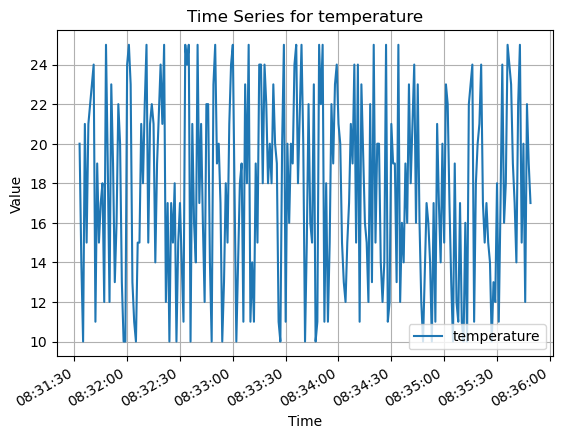

-------------------------------------------
	Graph humidity


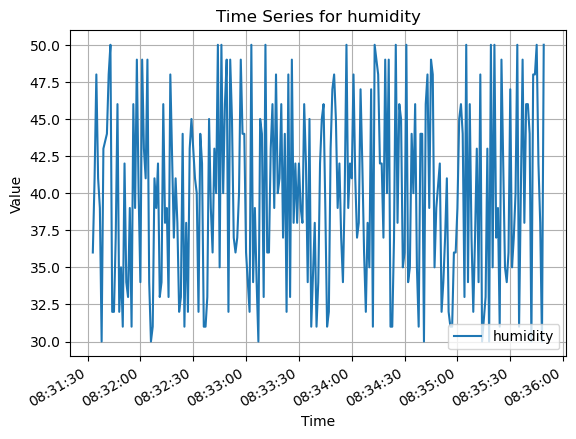

-------------------------------------------
	Graph co2


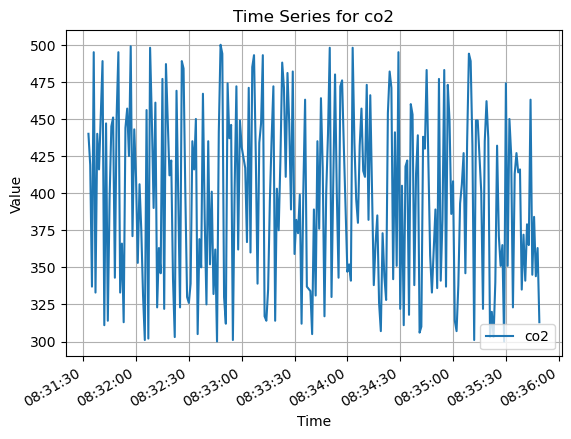

-------------------------------------------
	Graph tvoc


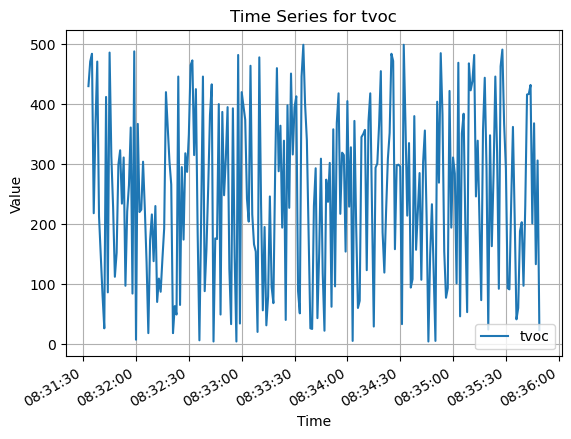

In [34]:
time_series = []
for k in range(len(labels)):
    data = result[result['measure_name'] == labels[k]]
    data_series = pd.Series(data=data['measure_value'].values, index=pd.to_datetime(data['time']))
    time_series.append(data_series)
    print(f'-------------------------------------------\n\tGraph {labels[k]}')
    data_series.plot(label=labels[k])
    plt.legend(loc='lower right')
    plt.title(f'Time Series for {labels[k]}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True) 
    plt.show()
    

In [35]:
# https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html
freq = "min" ## time measured in minutes
prediction_length = 80
# Prediction_length is the number of data that will remove for training data ex if the first select limit is 1000, for 4 labels
# it means that there is 250 rows per label, if prediction length is 48. Then 202 rows will be used to train the model 
# 250 will be used for testing the model
context_length = 72
data_length = 400
num_ts = 2
period = 24

hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10",
}


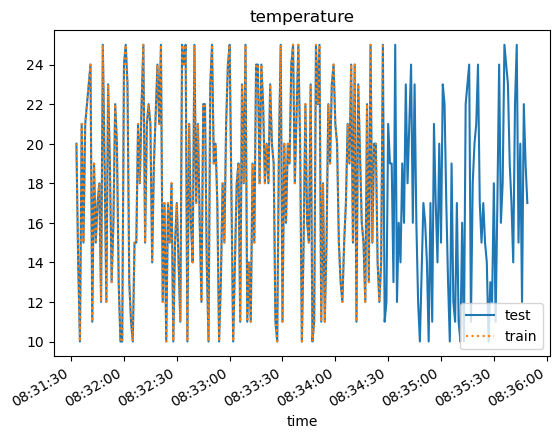

In [36]:
time_series_training = []
for ts in time_series:
    time_series_training.append(ts[:-prediction_length])
time_series[0].plot(label="test", title = "temperature")
time_series_training[0].plot(label="train", ls=":")

plt.legend()
plt.show()

In [37]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

encoding = "utf-8"
FILE_TRAIN = "train.json"
FILE_TEST = "test.json"

with open(FILE_TRAIN, "wb") as f: # Will contain X rows - prediction data
    for ts in time_series_training:
        f.write(series_to_jsonline(ts).encode(encoding))
        f.write("\n".encode(encoding))

with open(FILE_TEST, "wb") as f: # Will contain X rows
    for ts in time_series:
        f.write(series_to_jsonline(ts).encode(encoding))
        f.write("\n".encode(encoding))
        
s3 = boto3.client("s3")
s3.upload_file(FILE_TRAIN, bucket, prefix + "/data/train/" + FILE_TRAIN)
s3.upload_file(FILE_TEST, bucket, prefix + "/data/test/" + FILE_TRAIN)


In [28]:
image_uri = sagemaker.image_uris.retrieve("forecasting-deepar", boto3.Session().region_name)
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    base_job_name="ecosense-deepar",
    output_path=f"s3://{s3_output_path}",
)
estimator.set_hyperparameters(**hyperparameters)

data_channels = {"train": f"s3://{s3_data_path}/train/", "test": f"s3://{s3_data_path}/test/"}


estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: ecosense-deepar-2024-04-30-08-19-33-702


2024-04-30 08:19:33 Starting - Starting the training job...
2024-04-30 08:19:48 Starting - Preparing the instances for training...
2024-04-30 08:20:21 Downloading - Downloading input data...
2024-04-30 08:20:46 Downloading - Downloading the training image...............
2024-04-30 08:23:18 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[04/30/2024 08:23:30 INFO 139741021448000] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '

In [29]:
# Deploy endpoint
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    image_uri=image_uri,
    role=role,
)

INFO:sagemaker:Creating model with name: ecosense-deepar-2024-04-30-08-19-33-702
INFO:sagemaker:Creating endpoint-config with name ecosense-deepar-2024-04-30-08-19-33-702
INFO:sagemaker:Creating endpoint with name ecosense-deepar-2024-04-30-08-19-33-702


---------!

In [30]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.

        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points

        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length

    def predict(
        self,
        ts,
        cat=None,
        encoding="utf-8",
        num_samples=100,
        quantiles=["0.1", "0.5", "0.9"],
        content_type="application/json",
    ):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.

        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])

        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1] + pd.Timedelta(1, unit=self.freq) for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req, initial_args={"ContentType": content_type})
        return self.__decode_response(res, prediction_times, encoding)

    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles"],
            "quantiles": quantiles,
        }
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)

    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.date_range(
                start=prediction_times[k], freq=self.freq, periods=self.prediction_length
            )
            list_of_df.append(
                pd.DataFrame(
                    data=response_data["predictions"][k]["quantiles"], index=prediction_index
                )
            )
        return list_of_df
    
predictor = DeepARPredictor(endpoint_name=endpoint_name, sagemaker_session=sagemaker_session)
predictor.set_prediction_parameters(freq, prediction_length)

list_of_df = predictor.predict(time_series_training, content_type="application/json")
actual_data = time_series

for k in range(len(labels)):
    print(labels[k])
    print(list_of_df[k]["0.5"])

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


temperature
2024-04-30 08:19:04    14.053410
2024-04-30 08:20:04    14.027405
2024-04-30 08:21:04    14.076681
2024-04-30 08:22:04    13.750736
2024-04-30 08:23:04    14.557333
                         ...    
2024-04-30 09:34:04    11.435608
2024-04-30 09:35:04    11.746386
2024-04-30 09:36:04    11.650403
2024-04-30 09:37:04    11.560929
2024-04-30 09:38:04    11.471855
Freq: min, Name: 0.5, Length: 80, dtype: float64
humidity
2024-04-30 08:19:04    35.327179
2024-04-30 08:20:04    36.679832
2024-04-30 08:21:04    36.273033
2024-04-30 08:22:04    39.013844
2024-04-30 08:23:04    38.951866
                         ...    
2024-04-30 09:34:04    30.554058
2024-04-30 09:35:04    30.669144
2024-04-30 09:36:04    28.710506
2024-04-30 09:37:04    30.969662
2024-04-30 09:38:04    31.084387
Freq: min, Name: 0.5, Length: 80, dtype: float64
co2
2024-04-30 08:19:04    398.143280
2024-04-30 08:20:04    447.872101
2024-04-30 08:21:04    405.942596
2024-04-30 08:22:04    410.093048
2024-04-30 08:2

-------------------------------------------
	Prediction temperature


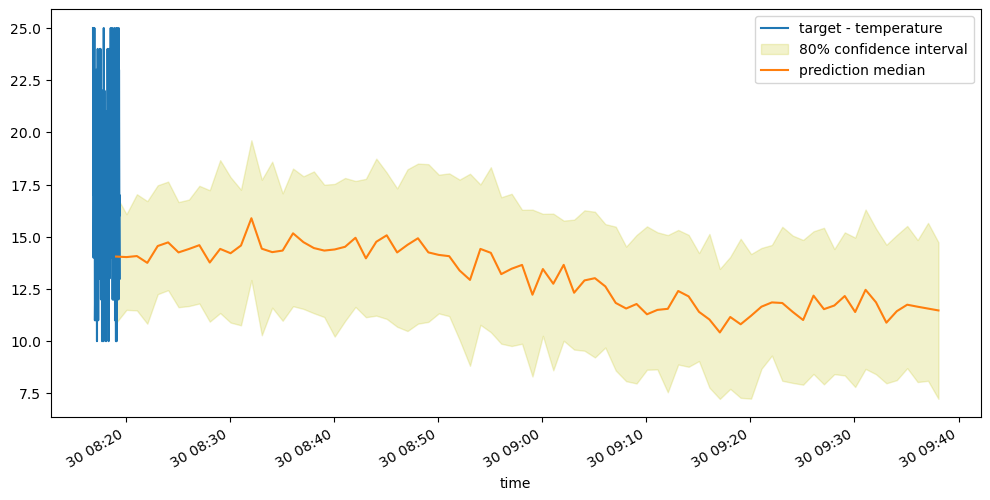

-------------------------------------------
	Prediction humidity


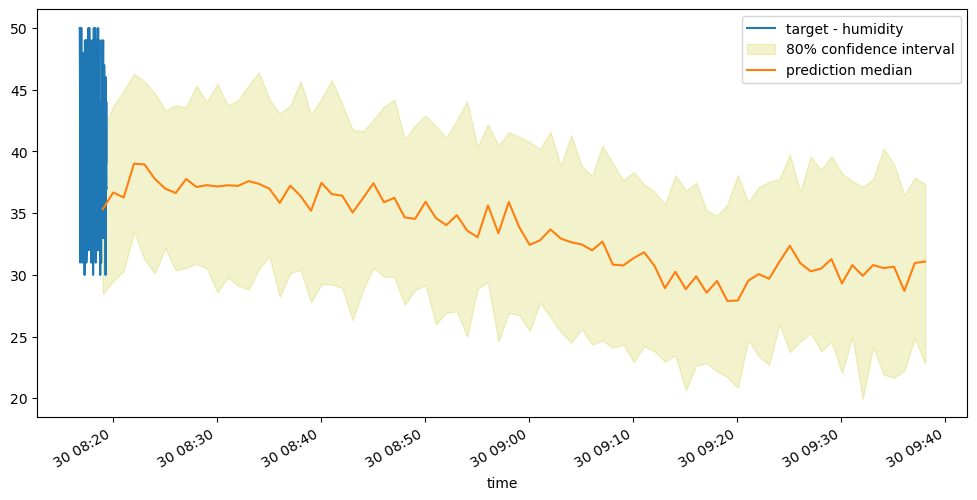

-------------------------------------------
	Prediction co2


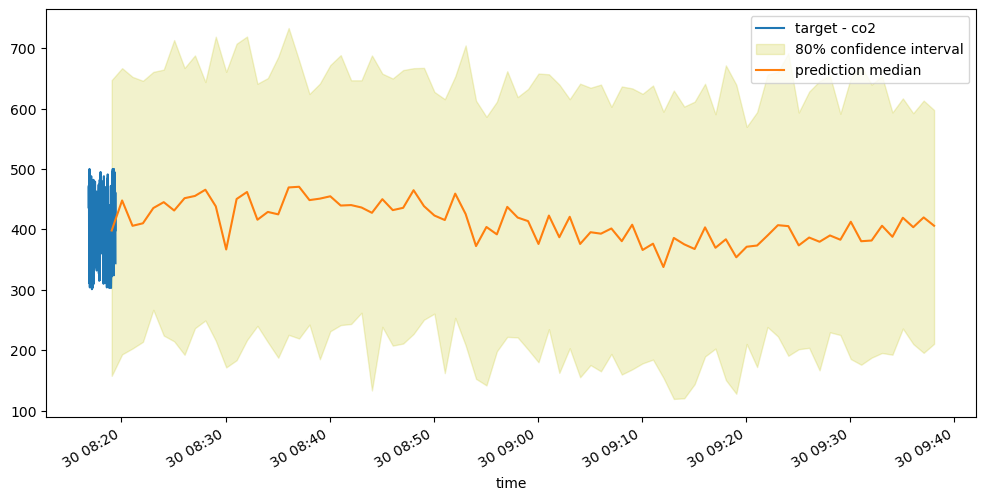

-------------------------------------------
	Prediction tvoc


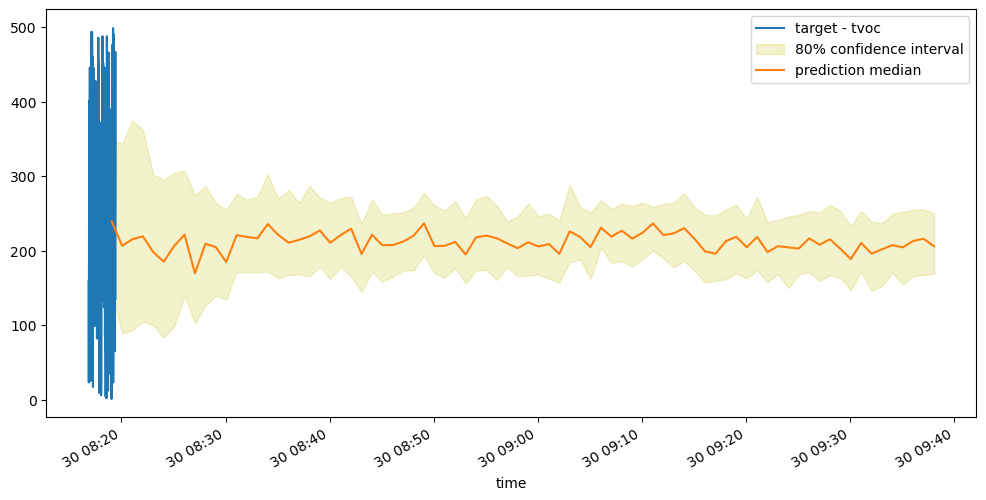

In [31]:
for k in range(len(list_of_df)):
    print(f'-------------------------------------------\n\tPrediction {labels[k]}')
    plt.figure(figsize=(12, 6))
    actual_data[k][-prediction_length - context_length :].plot(label=f'target - {labels[k]}') # Actual data in blue
    p10 = list_of_df[k]["0.1"] # Prediction min
    p50 = list_of_df[k]["0.5"] # Prediction median
    p90 = list_of_df[k]["0.9"] # Prediction max
    plt.fill_between(p10.index, p10, p90, color="y", alpha=0.2, label="80% confidence interval") # Prediction interval min to max
    p50.plot(label="prediction median") # Prediction data using median prediction in red
    plt.legend()
    plt.show()

In [ ]:
# ## Delete the endpoint
#  sagemaker_session.delete_endpoint(endpoint_name)